#### Preliminaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib as mpl
from matplotlib.patches import Rectangle
import seaborn as sns
import statsmodels.api as sm
from ipywidgets import interact, interactive, FloatSlider, IntSlider

In [2]:
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import rc
font = {'size'   : 18}
rc('font', **font)

In [3]:
data = pd.read_csv('../data/Table2_Hunt_2013_edit.csv')

Data from [Many correlation coefficients, null hypoteses, and high value](https://csegrecorder.com/columns/view/value-of-integrated-geophysics-201312), Lee Hunt, CSEG Recorder, December 2013.

### Introduction

Folowing Brown's [Stats without tears](https://brownmath.com/swt/) notation on Inferential Statistics, there's a distinction between __Inferences about Linear regression and Inferences about Linear Correlation.__ 

Here's a breakdown of the estimates I have investigated in eahc of those categories.

1. __Inferences about Linear regression__
    1. Confidence Interval for mean response to a Particular x
    2. Prediction Interval for responses to a particular x
    3. Confidence Interval for the slope  of the regression line
    4. Confidence Interval for the intercept of the regression line
2. __Inferences about Linear Correlation__
    1. Critical r
    2. Confidence Interval for the correlation coefficient


### 1.A Confidence Interval for the mean response to a particular x

This is the Confidence Interval that tells us in what range Production is likely to be (95% confidence level) for a specific newly well that drilled through a reservoir with Gross Pay = x.

If you like Seaborn aesthetic, and are happy to just plot it as a filled region, you get this Confidence Interval for free [with __`seaborn.regplot`__](https://seaborn.pydata.org/generated/seaborn.regplot.html). 

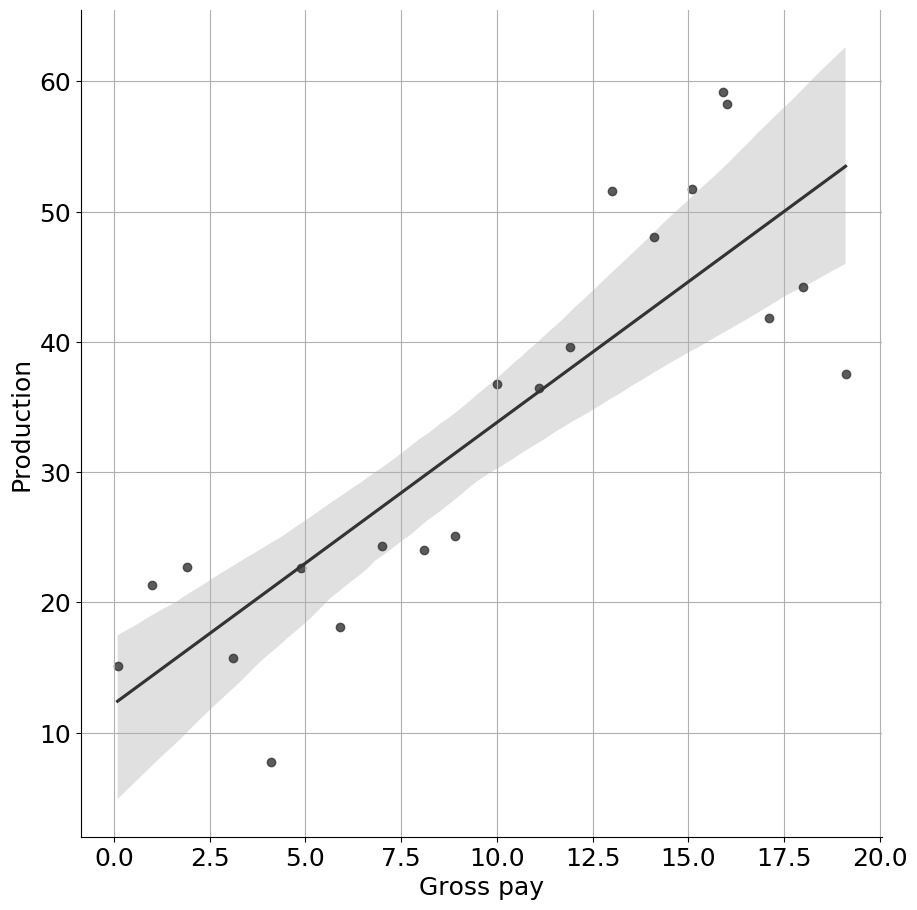

In [4]:
g = sns.PairGrid(data, y_vars=["Production"], x_vars=["Gross pay"], height=9)
g.map(sns.regplot, color="0.2")
plt.grid()
plt.show()

### 1.B Prediction Interval for responses to a particular x

I have previously showcased a useful application of the Prediction Interval, to assess drilling economic risk, in [Geoscience_ML_notebook 3](https://github.com/mycarta/predict/blob/master/Geoscience_ML_notebook_3.ipynb). As defined in that notebook, one can look at any specific value of x, say x0, and at that x0 find an interval around the predicted value of y, y0 such that there is a 95% probability that the value of a new point, for example the next well to be drilled, is within this interval. I find this __prediction of a future value__ more interesting and of practical use than the __prediction of the mean response__. 

In [Python OLS confidence interval and prediction interval](https://github.com/mycarta/Data-science-tools-petroleum-exploration-and-production/blob/master/Python/notebooks/Python_OLS_confidence_interval_and_prediction_interval.ipynb) I introduced my utility function to performs OLS regression using `statsmodels`, and then plot:
- The X, y data points
- The regression line and its equation
- The Confidence Interval region
- The Prediction Interval band
- The Confidence Interval for a selected point (optional)
- The Prediction Interval for a selected point (optional)

Below is the plot produced by the said function. Compare it with the `seaborn` plot above. 

<div>
<img src="https://mycarta.files.wordpress.com/2020/02/plot_ci_pi_21.png" width="900"/>
</div>

### 1.C and 1.D - Confidence Intervals for the slope and for the intercept of a regression

As suggested by the title, there are also a Confidence Interval [for the slope](https://brownmath.com/stat/infregr.htm#SlopeCI) and a Confidence Interval [for the intercept](https://brownmath.com/stat/infregr.htm#HTCIIntercept).

In a future notebook I will show how to obtain them both using Python. For now, please enjoy  😂  this animation prepared in Excel 🤯. It shows the confidence interval for the slope as the number of wells drops form 21 to 5. In  the latter case one observes that the slope can be positive, negative, or zero, which means that we cannot rule out that Production does not depend on Gross Pay, i.e. that Production and Gross Pay are independent.

<img src="https://mycarta.files.wordpress.com/2020/02/ci_slope.gif">

### 2. Inferences about Linear Correlation

This is the focus in the remainder of the notebook.

As I've written in the first notebook in this Repo, [Data loading, visualization, significance testing](https://github.com/mycarta/Data-science-tools-petroleum-exploration-and-production/blob/master/Python/notebooks/Python_data_science_tools%20_petroleum_exploration_production.ipynb), I find the critical r very useful in the context univariate screening of variables prior to multiple regression work. The __critical r is the value of the correlation coefficient at which you can rule out chance as an explanation for the relationship between variables observed in the sample__.

I look at it in combination with the confidence interval of the correlation coefficient, as shown below.

#### Helper functions

##### Function to round a float to the nearest 0.5

(From [this Stack Overflow answer](https://stackoverflow.com/a/4265592/1034648)). Used by `r_crit` function below.

In [5]:
def round_to(n, precision):
    correction = 0.5 if n >= 0 else -0.5
    return int( n/precision+correction ) * precision

def round_to_05(n):
    return round_to(n, 0.05)

##### Critical r test

In [6]:
def r_crit(nwells):
    """
    Function to calculate the value of critical correlation coefficient: 
    that is, the value of the correlation coefficient at which you can rule out chance as 
    an explanation for the relationship in the sample, given a confidence level of 95%.
    nwells-2 is the degrees of freedom.
    Reference: https://brownmath.com/stat/correl.htm#DecisionPoints
    
     Parameters
    ----------
    nwells: integer
        the number of wells
    
    Returns
    -------
    r_crit: formatted float
        The critical correlation coefficient
    """
    t = stats.t.isf(0.025, nwells-2) # nwells-2 is the degrees of freedom
    r_crit = t/np.sqrt((nwells-2)+ np.power(t,2))
    return float("{0:.2f}".format(r_crit))

##### Confidence interval for the correlation coefficient

In [7]:
def confInt(r, nwells):
    """
    Function to calculate the confidence interval interval for the population
    correlation coefficient, given a confidence level of 95%, the number of
    wells (and from that the degrees of freedom), and the sample correlation coefficient.
    For the details of the calculation, see Brown at: http://brownmath.com/stat/correl.htm#CI
    Notice that the function can take directly arrays as parameters (broadcasting).
    Reference: https://brownmath.com/stat/correl.htm#CI
    
    Parameters
    ----------
    r: float
        the sample correlation coefficient   
    nwells: integer
        the number of wells
    
    Returns
    -------
    RCI_u, RCI_l: tuple
        The upper and lower limits of the confidence interval for the correlation coefficient
    """
    z_crit = stats.norm.ppf(.975)
    std_Z = 1/np.sqrt(nwells-3)
    E = z_crit*std_Z
    Z_star = 0.5*(np.log((1+r)/(1.0000000000001-r)))
    ZCI_l = Z_star - E
    ZCI_u = Z_star + E
    RCI_l = (np.exp(2*ZCI_l)-1)/(np.exp(2*ZCI_l)+1)
    RCI_u = (np.exp(2*ZCI_u)-1)/(np.exp(2*ZCI_u)+1)
    return RCI_u, RCI_l

With the above tools in hands, and with a given number of wells and a sample correlation coefficient, let's proceed to answer the question: "__what is the 95% confidence interval for the correlation coefficient in the population?__"

#### Heatmap visualization

To do that, I create a set of confidence intervals for the population correlation coefficient as a function of the sample correlation coefficient varying from 0 to 1, in increments of 0.5, and turn the result in a heatmap.

Let's create the heatmap, then discuss the insights. I will first use all 21 wells in the dataset. This example is from [Python data science tools for petroleum exploration and production](https://github.com/mycarta/Data-science-tools-petroleum-exploration-and-production/blob/master/Python/notebooks/Python_data_science_tools%20_petroleum_exploration_production.ipynb).

In [8]:
crr = np.arange(0.0,1.05,0.05).round(decimals=2)
cm21 = np.asarray(confInt(crr, 21)) 

In [9]:
CI21 = pd.DataFrame(cm21, index = ['CI_UPPER', 'CI_LOWER'], 
                    columns = [" r = " + mp for mp in map(str, crr)])

In [10]:
print ('critical r = ' + str(r_crit(21)))

critical r = 0.43


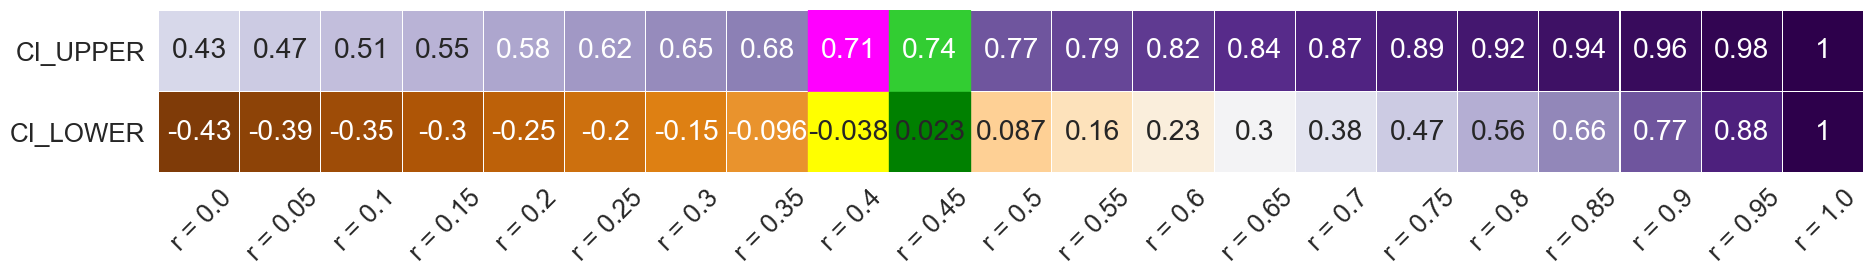

In [11]:
sns.set(font_scale=1.7)
fig, ax = plt.subplots(figsize=(22, 4))
h = sns.heatmap(CI21, annot=True, cmap='PuOr', square=True, linewidths=0.01, cbar=False)
plt.xticks(rotation=45)
h.add_patch(Rectangle((8,0), 1, 1, fill=True, color = 'magenta')) 
h.add_patch(Rectangle((8,1), 1, 1, fill=True, color = 'yellow')) 
h.add_patch(Rectangle((9,0), 1, 1, fill=True, color = 'limegreen')) 
h.add_patch(Rectangle((9,1), 1, 1, fill=True, color = 'green'))
ax.set_ylim(CI21.shape[0]-0.01, -0.01)
plt.show();

This tells us a bit more than just the critical r test. 

We see that for the correlation of __Production and Gross Pay (sample cc = 0.85), the 95% confidence interval for the population correlation coefficient is 0.66-0.94 (not bad!). On the other hand, for the correlation of Production and Pressure (sample cc = 0.38) the lower confidence limit (-0.038, highlighted in yellow) is below zero, which means we cannot confidently reject the hypothesis that there is no linear association between Pressure and Production in the population.__

**N.B.** This DOES NOT prove independence between Pressure and Production; it just means that with the available data we can’t reach a conclusion either way, and more data points are needed. 

There's another interesting point that we can take home, following a similar discussion in [Quantitative use of seismic attributes for reservoir characterization](http://74.3.176.63/publications/recorder/2002/06jun/jun02-quantitative-use.pdf). From this heatmap we can evince it would take at least a correlation coefficient of 0.45 (with a bit of rounding, considering that the critical r = 0.43) for a correlation to have both upper (highlighted in light green) and lower (highlighted in dark green) confidence limits above zero; **BUT** even then, the lower confidence limit would still only be 0.023 (dark green). This is food for thougth.

It is interesting now to see what happens with fewer wells, let's say 5.

In [12]:
print ('critical r = ' + str(r_crit(5)))

critical r = 0.88


In [13]:
cm5 = np.asarray(confInt(crr, 5))

In [14]:
CI5 = pd.DataFrame(cm5, index = ['CI_UPPER', 'CI_LOWER'], columns = [" r = " + mp for mp in map(str, crr)])

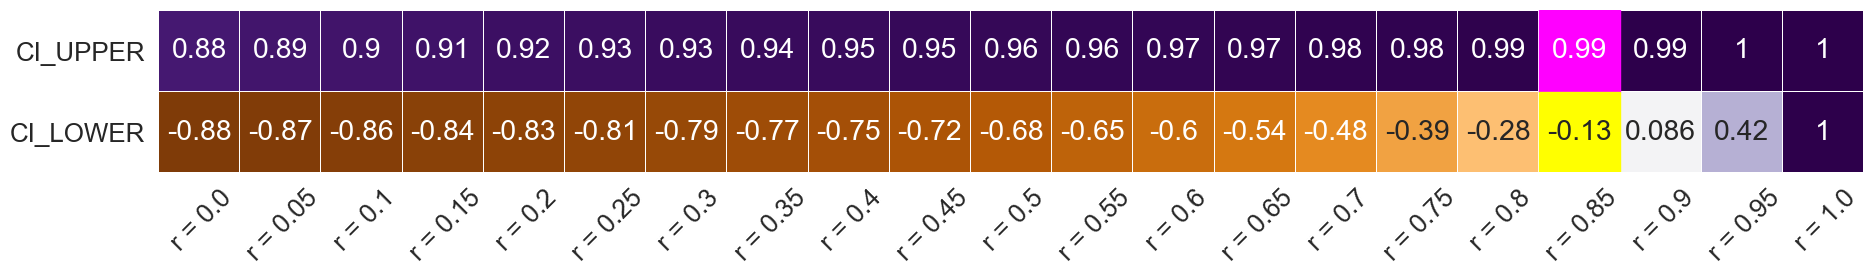

In [15]:
sns.set(font_scale=1.7)
fig, ax = plt.subplots(figsize=(22, 4))
h = sns.heatmap(CI5, annot=True, cmap='PuOr', square=True, linewidths=0.01, cbar=False)
plt.xticks(rotation=45)
h.add_patch(Rectangle((17,0), 1, 1, fill=True, color = 'magenta')) 
h.add_patch(Rectangle((17,1), 1, 1, fill=True, color = 'yellow')) 
ax.set_ylim(CI5.shape[0]-0.01, -0.01)
plt.show();

__With only 5 wells, _technically_ not even Gross Pay does not pass these tests, as for a correlation coefficient of 0.85 the critical correlation coefficient is 0.88, and also the lower confidence limit is negative (-0.13, highlighted in yellow)!!__. I say _technically_ because we are testing a hypothesis based on a physical expectations (through [Darcy's Law](https://en.wikipedia.org/wiki/Darcy%27s_law)) that there should be a relationship between Gross pay and Production. Things would be different had this been an unknown variable without a hypotesing explaining the relationship: this is where the domain knowledge comes into play; the test is only a guide in making informed choises.

### A better, interactive visualization

OK, The heatmap looks really nice. But it takes a lot of work by hand to color the correct rectangles. I could automate it, and also incorporate the critical r, but there's a better way to combine and visualize the two, which takes advantage of the Jupyter interactive functionality (`ipywidgets`). The tool below will give the ability to explore the significance of the sample correlation coefficient observed as its value, and the number of wells change.

THe animation below is an example, using the same variables, number of wells and correlation coefficient from the first heatmap above.

<img src="https://mycarta.files.wordpress.com/2020/02/ci_interactive_21wells.gif">

##### Define the function to do all the interactive plotting and also output array

In [16]:
def conf_int_demo(r, nwells):
    """
    Interactive plot of the relationship between the observed (user
    input)  sample correlation coefficient, the critical r, and the
    confidence interval for the population correlation coefficient,
    given a confidence level of 95%, and a user selected number of wells 
    (from which the degrees of freedom are calculated).  
    """

    ###### set up variables ######
    crr = np.arange(0.0,1.02,0.02).round(decimals=2)
    cm = np.asarray(confInt(crr, nwells))
    cm_test = np.asarray(confInt(r, nwells))

    ###### set up figure ######
    fig, ax = plt.subplots(figsize=(12,15))
    plt.title('Confidence interval for correlation coefficient -' + str(nwells) + ' wells')
    ax.set_ylim([-1.05,1.05])
    ax.set_xlim([0, 1])
    ax.set_ylabel('R', rotation = 0)
    ax.set_xlabel('r', rotation = 0)

    ###### plot reference lines, R = 0 and R = r ######
    ax.plot([0,1], [0, 1], 'k', linewidth= 3, alpha = 0.7)
    ax.plot([0,1], [0, 0], 'k', linewidth= 3, alpha = 0.7)
    
    
    ###### Plot CI upper and lower limits ######
    ax.plot(np.arange(0.00,1.02,0.02), cm[0,:],  'darkblue', linewidth= 4, alpha = 0.8, 
            label = ('95% CI - upper bound'))
    ax.plot(np.arange(0.00,1.02,0.02), cm[1,:], 'royalblue', linewidth= 4, alpha = 0.8, 
            label = ('95% CI - lower bound'))
    
    ###### Plot MINIMUM and MAXIMUM R points ######
    ax.scatter (r, cm_test[0], s=180, facecolors = 'g', edgecolors='k', 
                label = 'MAX R (' + str(nwells) + ' wells, CC = ' 
                + '{:.2f}'.format(r) + ')', zorder=10)
    if cm_test[1]>= 0:
        ax.scatter (r, cm_test[1], s=200, facecolors = 'g', edgecolors='k', 
                    label = 'MIN R (' + str(nwells) + ' wells, CC = ' 
                    + '{:.2f}'.format(r) + ')',  zorder=10)
        ax.vlines( r, ymin=cm_test[1], ymax=cm_test[0], colors='g', 
                  linestyles='dashed', linewidth= 3)
        ax.vlines(r, ymin=-1.05, ymax=cm_test[1], colors='k', linestyles='dotted', linewidth= 2)
    else:
        ax.scatter (r, cm_test[1], s=200, facecolors = 'm', edgecolors='k', 
                    label = 'MIN  R (' + str(nwells) + ' wells, CC = ' 
                    + '{:.2f}'.format(r) + ')', zorder=10)  
        ax.vlines(r, ymin=0, ymax=cm_test[0], colors='g', linestyles='dashed', linewidth= 3)
        ax.vlines(r, ymin=cm_test[1], ymax=0, colors='m', linestyles='dashed', linewidth= 3)
        ax.vlines(r, ymin=-1.05, ymax=cm_test[1], colors='k', linestyles='dotted', linewidth= 2)

    # plot critical r point
    ax.scatter (r_crit(nwells), 0, s=200, facecolors = 'w', edgecolors='k', 
                label = 'Critical CC = ' + '{:.2f}'.format(r_crit(nwells)), zorder=10)

    plt.legend(loc=4)
    plt.grid()
    plt.show()

    #return (__ , __) # this will be used to access the CI as output 

#### Call the function and display the interactive plot

In [17]:
np.seterr(over='ignore')
rslt = interactive(conf_int_demo, r=FloatSlider(min=0, max=1.02, step=0.01, value = 0.4), 
                   nwells = IntSlider(min=5, max=60, step=1, value = 15))

In [18]:
display(rslt)

interactive(children=(FloatSlider(value=0.4, description='r', max=1.02, step=0.01), IntSlider(value=15, descri…

### Acknowledgments

#### The idea for this interactive tool was inspired by a presentation by [Christian Mogensen](https://www.linkedin.com/in/christian-mogensen/), a former colleague at [DONG Energy](https://en.wikipedia.org/wiki/%C3%98rsted_(company)).